In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# GPU까지 제어
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# CUDA 연산을 결정적으로 만들기
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

 학습 함수 생성

In [4]:
@torch.no_grad()
def _make_labels(batch_size, device, real_val=1.0, fake_val=0.0):
    valid = torch.full((batch_size, 1), real_val, device=device)
    fake  = torch.full((batch_size, 1), fake_val,  device=device)
    return valid, fake

def train_one_epoch(
    generator: nn.Module,
    discriminator: nn.Module,
    train_loader: DataLoader,
    optimizer_G: torch.optim.Optimizer,
    optimizer_D: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    latent_dim: int,
    *,
    real_target: float = 1.0,
    fake_target: float = 0.0,
):
    generator.train()
    discriminator.train()

    running_d, running_g, count = 0.0, 0.0, 0

    for imgs, labels in train_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)
        bsz    = imgs.size(0)

        # --------------------
        # Discriminator
        # --------------------
        optimizer_D.zero_grad(set_to_none=True)
        valid, fake = _make_labels(bsz, device, real_target, fake_target)

        real_out  = discriminator(imgs, labels)
        real_loss = criterion(real_out, valid)

        noise     = torch.randn(bsz, latent_dim, device=device)
        gen_imgs  = generator(noise, labels)

        fake_out  = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_out, fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # --------------------
        # Generator
        # --------------------
        optimizer_G.zero_grad(set_to_none=True)
        g_out  = discriminator(gen_imgs, labels)
        g_loss = criterion(g_out, valid)
        g_loss.backward()
        optimizer_G.step()

        running_d += d_loss.item()
        running_g += g_loss.item()
        count     += 1

    avg_d = running_d / max(1, count)
    avg_g = running_g / max(1, count)
    return avg_d, avg_g

샘플을 시각화 하는 함수

In [5]:
def visualize_samples(
    generator: nn.Module,
    num_classes: int,
    latent_dim: int,
    device: torch.device,
    *,
    n_row: int = 3,
    idx_to_class: dict | None = None,
):
    generator.eval()
    with torch.no_grad():
        n_col = num_classes
        total = n_row * n_col
        noise = torch.randn(total, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        gen_imgs = generator(noise, labels_sample).detach().cpu()

    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
    axs = axs if n_row > 1 else [axs]  # 1행일 때 처리
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            axs[i][j].imshow(gen_imgs[idx, 0], cmap="gray")
            axs[i][j].axis("off")
            if idx_to_class and i == 0:
                axs[i][j].set_title(idx_to_class.get(j, str(j)), fontsize=10)
    plt.tight_layout()
    plt.show()
    generator.train()

전체 학습 함수

In [6]:
def train(
    generator: nn.Module,
    discriminator: nn.Module,
    train_loader: DataLoader,
    optimizer_G: torch.optim.Optimizer,
    optimizer_D: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    latent_dim: int,
    num_classes: int,
    epochs: int,
    *,
    history: dict | None = None,
    sample_every: int = 10,
    real_target: float = 1.0,
    fake_target: float = 0.0,
    idx_to_class: dict | None = None,
):
    """
    - train_one_epoch(...)가 (avg_d, avg_g)를 반환한다고 가정
    - visualize_samples(...)가 생성 이미지를 출력한다고 가정
    - history를 외부에서 받아 업데이트 (누적 가능)
    """

    # 전달받은 history가 없으면 새로 생성
    if history is None:
        history = {"D": [], "G": []}

    for epoch in range(epochs):
        avg_d, avg_g = train_one_epoch(
            generator=generator,
            discriminator=discriminator,
            train_loader=train_loader,
            optimizer_G=optimizer_G,
            optimizer_D=optimizer_D,
            criterion=criterion,
            device=device,
            latent_dim=latent_dim,
            real_target=real_target,
            fake_target=fake_target,
        )

        history["D"].append(avg_d)
        history["G"].append(avg_g)

        print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d:.4f}  G_loss: {avg_g:.4f}")

        # 샘플 이미지 시각화
        if (epoch + 1) % sample_every == 0:
            visualize_samples(
                generator=generator,
                num_classes=num_classes,
                latent_dim=latent_dim,
                device=device,
                n_row=3,
                idx_to_class=idx_to_class,
            )

    return history

소실함수를 그래프로 그리는 함수

In [7]:
def plot_history(history: dict):
    epochs = range(1, len(history["D"]) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, history["D"], label="D_loss (epoch avg)")
    plt.plot(epochs, history["G"], label="G_loss (epoch avg)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Loss per Epoch (Averages)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
image_size = 28 # Fashion MNIST 이미지 크기

In [36]:

# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

num_classes = len(idx_to_class) # 10개 클래스
latent_dim = 100 # 잠재 공간 차원

In [31]:
image_size = 32
transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),   # [-1,1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

num_classes = len(idx_to_class) # 10개 클래스
latent_dim = 100 # 잠재 공간 차원

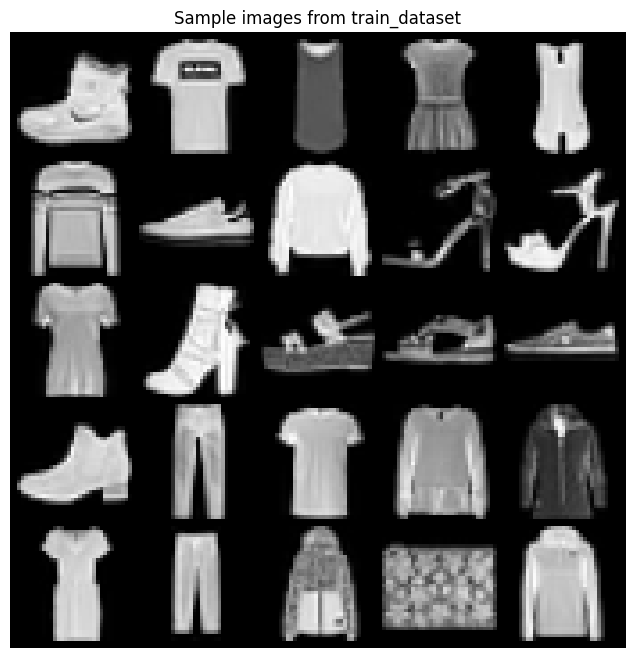

라벨들: ['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal', 'T-shirt/top', 'Ankle boot', 'Sandal', 'Sandal', 'Sneaker', 'Ankle boot', 'Trouser', 'T-shirt/top', 'Shirt', 'Coat', 'Dress', 'Trouser', 'Coat', 'Bag', 'Coat']


In [40]:
def show_samples(dataset, n=25):
    imgs, labels = zip(*[dataset[i] for i in range(n)])   # 여러 (img,label) 추출
    imgs = torch.stack(imgs)                              # tuple → tensor (B,1,H,W)
    grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title("Sample images from train_dataset")
    plt.show()

    # 라벨 이름 출력
    print("라벨들:", [idx_to_class[int(l)] for l in labels])

# 사용
show_samples(train_dataset, n=25)

In [10]:
# 생성자 (Generator)
class Generator(nn.Module):
  def __init__(self):
      super(Generator, self).__init__()
      # 레이블 임베딩
      self.label_emb = nn.Embedding(num_classes, num_classes)

      self.init_size = image_size // 4  # 7

      self.l1 = nn.Sequential(
          nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
          nn.ReLU(inplace=True)
      )

      self.conv_blocks = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.Upsample(scale_factor=2),  # 7 → 14
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64, 0.8),
          nn.ReLU(inplace=True),
          nn.Upsample(scale_factor=2),  # 14 → 28
          nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
          nn.Tanh()  # 출력 범위 [-1, 1]
      )

  def forward(self, noise, labels):
      label_input = self.label_emb(labels)
      gen_input = torch.cat((noise, label_input), -1)
      out = self.l1(gen_input)
      out = out.view(out.size(0), 128, self.init_size, self.init_size)
      img = self.conv_blocks(out)
      return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()
      # 레이블을 단일 채널 값으로 임베딩
      self.label_emb = nn.Embedding(num_classes, 1)

      self.model = nn.Sequential(
          # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
          nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Flatten(),
          nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
          nn.Sigmoid()
      )

  def forward(self, img, labels):
      batch_size = img.size(0)
      label = self.label_emb(labels)
      label = label.view(batch_size, 1, 1, 1)
      label = label.expand(batch_size, 1, image_size, image_size)
      # 이미지와 레이블을 채널 차원에서 연결
      d_in = torch.cat((img, label), 1)
      validity = self.model(d_in)
      return validity

In [22]:
# ======== 전처리 설정 ======== #
image_size = 32  # 28로 유지해도 되지만 Conv 레이어 맞추려면 32 권장

# (1) 학습용 전처리 - 가벼운 증강 + 정규화
train_transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.RandomApply([transforms.RandomRotation(8)], p=0.5),       # ±8도 회전
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.05, 0.05))], p=0.5),  # ±5% 평행이동
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # [-1, 1] 범위 정규화
])

# (2) 테스트용 전처리 - 정규화만
test_transform = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# ======== 데이터셋 ======== #
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=test_transform
)

# ======== DataLoader ======== #
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# ======== 클래스 이름 매핑 ======== #
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
num_classes = len(idx_to_class)  # 10개 클래스
latent_dim = 100  # 잠재 공간 차원

In [26]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, image_size=32):
        super().__init__()
        self.num_classes = num_classes
        self.image_size  = image_size
        self.label_emb   = nn.Embedding(num_classes, 1)

        self.features = nn.Sequential(
            nn.Conv2d(2, 64, 3, 2, 1),  # H/2
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 3, 2, 1),# H/4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # -> (B,128,1,1)
        self.fc  = nn.Sequential(
            nn.Flatten(),               # (B,128)
            nn.Linear(128, 1),
            nn.Sigmoid()                # BCELoss일 때 사용
        )

    def forward(self, img, labels):
        b = img.size(0)
        lab = self.label_emb(labels.long()).view(b,1,1,1).expand(b,1,self.image_size,self.image_size)
        x  = torch.cat([img, lab], dim=1)
        h  = self.features(x)
        h  = self.gap(h).view(b, 128)
        return self.fc(h)

class Discriminator(nn.Module):
    def __init__(self, num_classes, image_size=32):
        super().__init__()
        self.num_classes = num_classes
        self.image_size  = image_size
        self.label_emb   = nn.Embedding(num_classes, 1)

        self.features = nn.Sequential(
            nn.Conv2d(2, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(128, 1)  # Sigmoid 없음(=logits)

    def forward(self, img, labels):
        b = img.size(0)
        lab = self.label_emb(labels.long()).view(b,1,1,1).expand(b,1,self.image_size,self.image_size)
        x  = torch.cat([img, lab], dim=1)
        h  = self.features(x)
        h  = self.gap(h).view(b, 128)
        return self.fc(h)  # logits

In [33]:
generator = Generator(latent_dim=latent_dim, num_classes=num_classes, image_size=image_size).to(device)
discriminator = Discriminator(num_classes=num_classes, image_size=image_size).to(device)

# 0) (선택) 로지츠 + Tanh 파이프라인일 때 권장 설정
# - G 마지막: Tanh  (출력 [-1,1])
# - D 마지막: Sigmoid 제거(=logits)
# - 손실: BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# 1) 옵티마이저 (TTUR 예시: D를 조금 빠르게)
optimizer_D = torch.optim.Adam(generator.parameters(), lr=4e-4, betas=(0.0, 0.9))
optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))


In [32]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

TypeError: Generator.__init__() missing 2 required positional arguments: 'latent_dim' and 'num_classes'

Epoch [1/30]  D_loss: 0.8690  G_loss: 1.4490
Epoch [2/30]  D_loss: 0.8499  G_loss: 1.9229
Epoch [3/30]  D_loss: 1.0736  G_loss: 1.2520
Epoch [4/30]  D_loss: 0.8944  G_loss: 1.6375
Epoch [5/30]  D_loss: 0.8397  G_loss: 1.1403
Epoch [6/30]  D_loss: 0.9398  G_loss: 1.7414
Epoch [7/30]  D_loss: 1.0535  G_loss: 1.2639
Epoch [8/30]  D_loss: 1.2979  G_loss: 1.2510
Epoch [9/30]  D_loss: 0.9231  G_loss: 2.3369
Epoch [10/30]  D_loss: 0.8433  G_loss: 1.3720


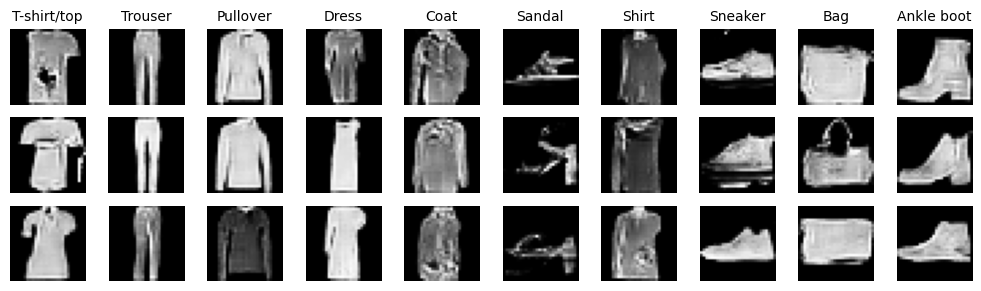

Epoch [11/30]  D_loss: 0.9244  G_loss: 1.0232
Epoch [12/30]  D_loss: 0.8605  G_loss: 1.3588
Epoch [13/30]  D_loss: 0.8657  G_loss: 1.6889
Epoch [14/30]  D_loss: 0.9322  G_loss: 1.0591
Epoch [15/30]  D_loss: 0.9608  G_loss: 1.1257
Epoch [16/30]  D_loss: 0.7511  G_loss: 1.6721
Epoch [17/30]  D_loss: 0.7999  G_loss: 1.5339
Epoch [18/30]  D_loss: 1.0381  G_loss: 1.5938
Epoch [19/30]  D_loss: 0.8142  G_loss: 2.7319
Epoch [20/30]  D_loss: 0.9304  G_loss: 0.7197


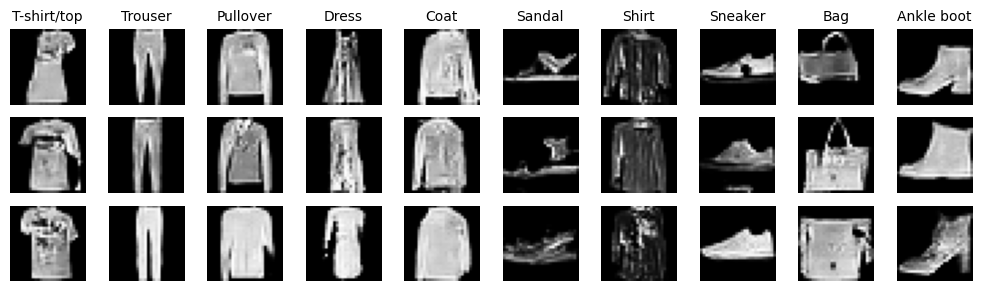

Epoch [21/30]  D_loss: 0.9194  G_loss: 2.3622
Epoch [22/30]  D_loss: 1.0082  G_loss: 1.0515
Epoch [23/30]  D_loss: 0.7140  G_loss: 1.7953
Epoch [24/30]  D_loss: 0.7175  G_loss: 3.2886
Epoch [25/30]  D_loss: 0.9278  G_loss: 2.1201
Epoch [26/30]  D_loss: 1.0003  G_loss: 1.0471
Epoch [27/30]  D_loss: 1.0478  G_loss: 1.0505
Epoch [28/30]  D_loss: 1.1199  G_loss: 2.5146
Epoch [29/30]  D_loss: 0.8998  G_loss: 1.6748
Epoch [30/30]  D_loss: 0.8776  G_loss: 2.2033


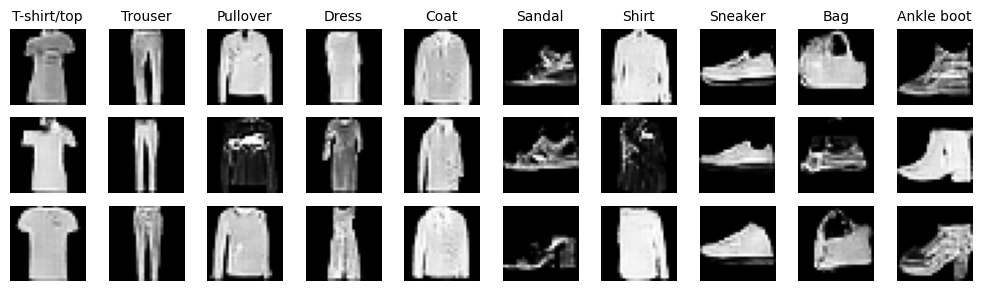

In [21]:
# 학습 루프
for epoch in range(epochs):
  for i, (imgs, labels) in enumerate(train_loader):
      batch_size_current = imgs.size(0)
      imgs = imgs.to(device)
      labels = labels.to(device)

      valid = torch.ones(batch_size_current, 1, device=device)
      fake  = torch.zeros(batch_size_current, 1, device=device)

      # 판별자 학습
      optimizer_D.zero_grad()
      real_loss = criterion(discriminator(imgs, labels), valid)

      noise = torch.randn(batch_size_current, latent_dim, device=device)
      gen_labels = labels
      gen_imgs = generator(noise, gen_labels)
      fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake)
      d_loss = real_loss + fake_loss
      d_loss.backward()
      optimizer_D.step()

      # 생성자 학습
      optimizer_G.zero_grad()
      g_loss = criterion(discriminator(gen_imgs, labels), valid)
      g_loss.backward()
      optimizer_G.step()

  print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

  # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
  if (epoch + 1) % 10 == 0:
      generator.eval()
      n_row = 3               # 각 클래스당 3개씩
      n_col = num_classes     # 총 10개 클래스
      total_samples = n_row * n_col
      noise = torch.randn(total_samples, latent_dim, device=device)
      labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
      gen_imgs = generator(noise, labels_sample).detach().cpu()

      fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
      for i in range(n_row):
          for j in range(n_col):
              idx = i * n_col + j
              axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
              axs[i, j].axis('off')
              if i == 0:
                  axs[i, j].set_title(idx_to_class[j], fontsize=10)
      plt.tight_layout()
      plt.show()
      generator.train()

- 해당은 seed를 무작위성을 했을 때 loss 확인

Epoch [1/30]  D_loss: 0.9243  G_loss: 1.3399
Epoch [2/30]  D_loss: 0.9941  G_loss: 1.2937
Epoch [3/30]  D_loss: 1.1038  G_loss: 1.1748
Epoch [4/30]  D_loss: 1.1202  G_loss: 1.1479
Epoch [5/30]  D_loss: 1.1294  G_loss: 1.1487
Epoch [6/30]  D_loss: 1.1356  G_loss: 1.1529
Epoch [7/30]  D_loss: 1.1321  G_loss: 1.1580
Epoch [8/30]  D_loss: 1.1269  G_loss: 1.1705
Epoch [9/30]  D_loss: 1.1221  G_loss: 1.1841
Epoch [10/30]  D_loss: 1.1187  G_loss: 1.1941


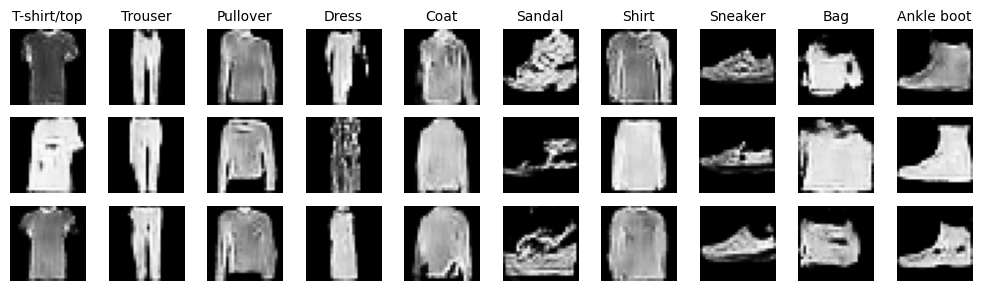

Epoch [11/30]  D_loss: 1.1070  G_loss: 1.2145
Epoch [12/30]  D_loss: 1.0971  G_loss: 1.2323
Epoch [13/30]  D_loss: 1.0971  G_loss: 1.2469
Epoch [14/30]  D_loss: 1.0882  G_loss: 1.2597
Epoch [15/30]  D_loss: 1.0769  G_loss: 1.2737
Epoch [16/30]  D_loss: 1.0747  G_loss: 1.2940
Epoch [17/30]  D_loss: 1.0694  G_loss: 1.3067
Epoch [18/30]  D_loss: 1.0639  G_loss: 1.3176
Epoch [19/30]  D_loss: 1.0586  G_loss: 1.3268
Epoch [20/30]  D_loss: 1.0518  G_loss: 1.3377


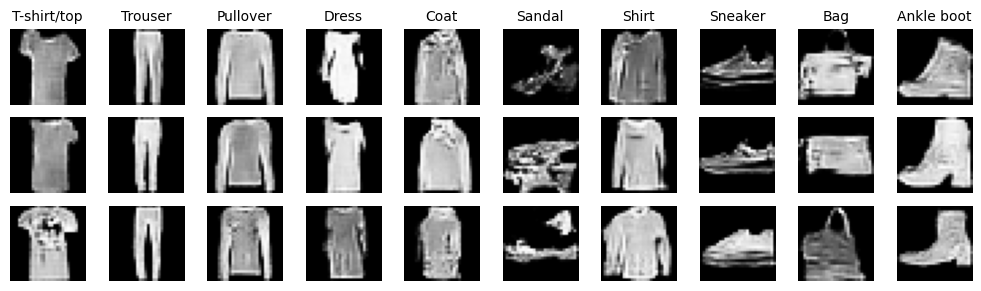

Epoch [21/30]  D_loss: 1.0531  G_loss: 1.3474
Epoch [22/30]  D_loss: 1.0518  G_loss: 1.3544
Epoch [23/30]  D_loss: 1.0466  G_loss: 1.3633
Epoch [24/30]  D_loss: 1.0498  G_loss: 1.3623
Epoch [25/30]  D_loss: 1.0506  G_loss: 1.3670
Epoch [26/30]  D_loss: 1.0477  G_loss: 1.3695
Epoch [27/30]  D_loss: 1.0455  G_loss: 1.3779
Epoch [28/30]  D_loss: 1.0495  G_loss: 1.3753
Epoch [29/30]  D_loss: 1.0399  G_loss: 1.3905
Epoch [30/30]  D_loss: 1.0416  G_loss: 1.3935


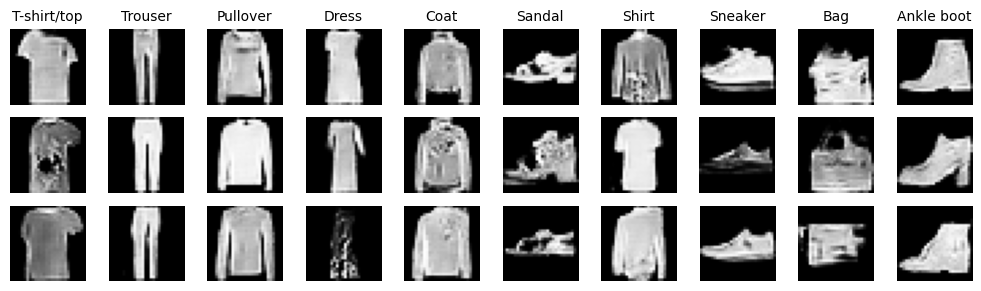

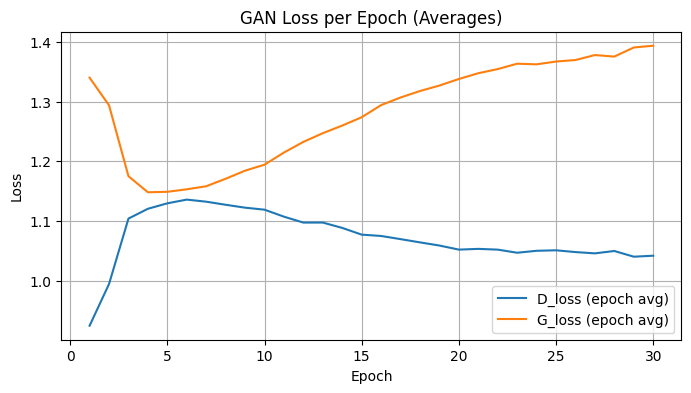

In [14]:
# history를 외부에서 선언
history = {"D": [], "G": []}

# 학습 수행 (기존 history를 그대로 넘겨줌)
history = train(
    generator, discriminator, train_loader,
    optimizer_G, optimizer_D, criterion,
    device, latent_dim, num_classes, epochs,
    history=history,                # 전달됨
    sample_every=10,
    real_target=0.9, fake_target=0.0,  # 라벨 스무딩 적용 가능
    idx_to_class=idx_to_class
)

plot_history(history)

- 초기 epoch를 돌렸을때는 판별자가 생성자보다 범위가 약함
- 중반으로 갈수록 균형이 생기기 시작함
- 후반으로 갈 수록 loss가 점점 줄어들면서 판별자가 생성자를 미니게임에서 이기김

이미지 전처리를 하고 나서 뭔가 이상해서 그렇다면 사이즈만 변경해서 다시 해봐야징!!

Epoch [1/30]  D_loss: 2.2552  G_loss: 0.3914
Epoch [2/30]  D_loss: 2.6416  G_loss: 0.3256
Epoch [3/30]  D_loss: 2.6439  G_loss: 0.3254
Epoch [4/30]  D_loss: 2.6411  G_loss: 0.3253
Epoch [5/30]  D_loss: 2.6390  G_loss: 0.3252
Epoch [6/30]  D_loss: 2.6367  G_loss: 0.3252
Epoch [7/30]  D_loss: 2.6351  G_loss: 0.3252
Epoch [8/30]  D_loss: 2.6336  G_loss: 0.3251
Epoch [9/30]  D_loss: 2.6327  G_loss: 0.3251
Epoch [10/30]  D_loss: 2.6321  G_loss: 0.3251


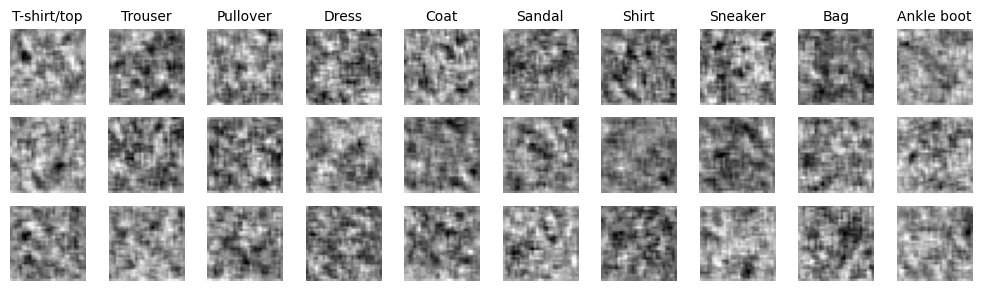

Epoch [11/30]  D_loss: 2.6317  G_loss: 0.3251
Epoch [12/30]  D_loss: 2.6313  G_loss: 0.3251
Epoch [13/30]  D_loss: 2.6311  G_loss: 0.3251
Epoch [14/30]  D_loss: 2.6310  G_loss: 0.3251
Epoch [15/30]  D_loss: 2.6308  G_loss: 0.3251
Epoch [16/30]  D_loss: 2.6308  G_loss: 0.3251
Epoch [17/30]  D_loss: 2.6308  G_loss: 0.3251
Epoch [18/30]  D_loss: 2.6306  G_loss: 0.3251
Epoch [19/30]  D_loss: 2.6305  G_loss: 0.3251
Epoch [20/30]  D_loss: 2.6306  G_loss: 0.3251


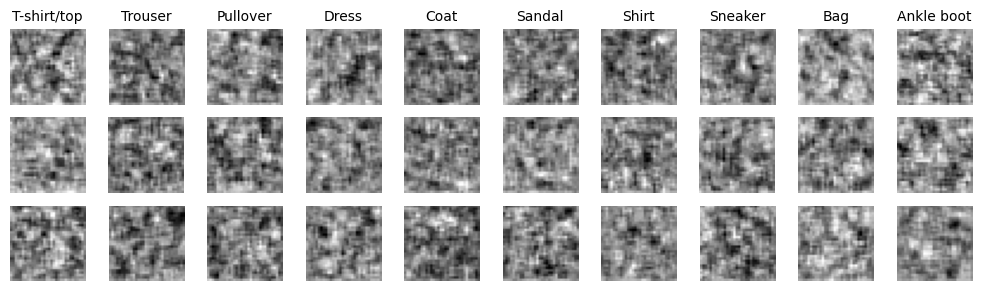

Epoch [21/30]  D_loss: 2.6306  G_loss: 0.3251
Epoch [22/30]  D_loss: 2.6306  G_loss: 0.3251
Epoch [23/30]  D_loss: 2.6306  G_loss: 0.3251
Epoch [24/30]  D_loss: 2.6307  G_loss: 0.3251
Epoch [25/30]  D_loss: 2.6310  G_loss: 0.3251
Epoch [26/30]  D_loss: 2.6312  G_loss: 0.3251
Epoch [27/30]  D_loss: 2.6312  G_loss: 0.3251
Epoch [28/30]  D_loss: 2.6314  G_loss: 0.3251
Epoch [29/30]  D_loss: 2.6315  G_loss: 0.3251
Epoch [30/30]  D_loss: 2.6319  G_loss: 0.3251


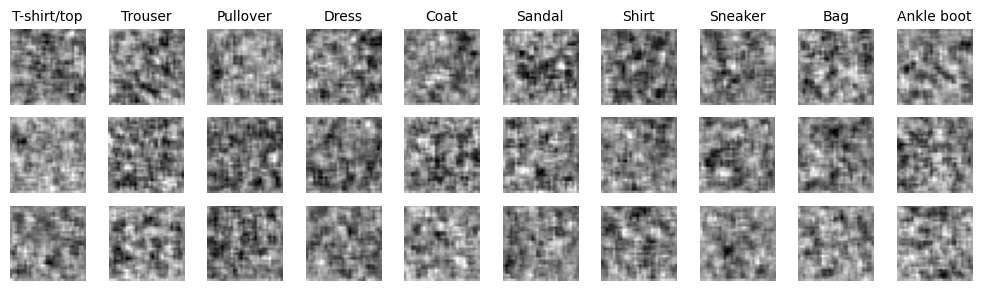

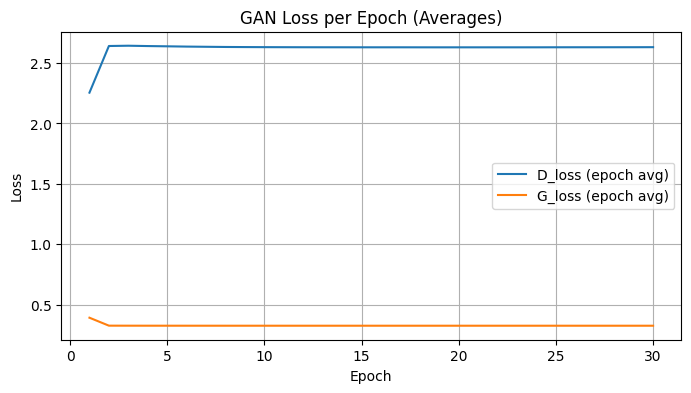

In [30]:
# history를 외부에서 선언
history = {"D": [], "G": []}

# 학습 수행 (기존 history를 그대로 넘겨줌)
history = train(
    generator, discriminator, train_loader,
    optimizer_G, optimizer_D, criterion,
    device, latent_dim, num_classes, epochs,
    history=history,                # 전달됨
    sample_every=10,
    real_target=0.9, fake_target=0.0,  # 라벨 스무딩 적용 가능
    idx_to_class=idx_to_class
)

plot_history(history)

Epoch [1/30]  D_loss: 2.2377  G_loss: 0.3938
Epoch [2/30]  D_loss: 2.6334  G_loss: 0.3254
Epoch [3/30]  D_loss: 2.6359  G_loss: 0.3253
Epoch [4/30]  D_loss: 2.6372  G_loss: 0.3252
Epoch [5/30]  D_loss: 2.6378  G_loss: 0.3252
Epoch [6/30]  D_loss: 2.6377  G_loss: 0.3251
Epoch [7/30]  D_loss: 2.6379  G_loss: 0.3251
Epoch [8/30]  D_loss: 2.6370  G_loss: 0.3251
Epoch [9/30]  D_loss: 2.6364  G_loss: 0.3251
Epoch [10/30]  D_loss: 2.6360  G_loss: 0.3251


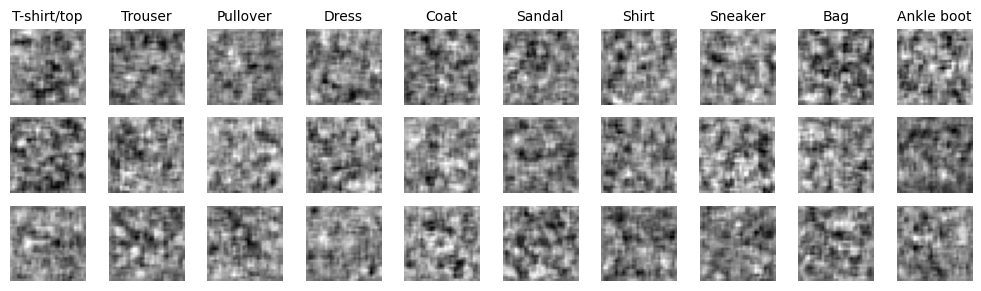

Epoch [11/30]  D_loss: 2.6359  G_loss: 0.3251
Epoch [12/30]  D_loss: 2.6354  G_loss: 0.3251
Epoch [13/30]  D_loss: 2.6347  G_loss: 0.3251
Epoch [14/30]  D_loss: 2.6340  G_loss: 0.3251
Epoch [15/30]  D_loss: 2.6332  G_loss: 0.3251
Epoch [16/30]  D_loss: 2.6328  G_loss: 0.3251
Epoch [17/30]  D_loss: 2.6326  G_loss: 0.3251
Epoch [18/30]  D_loss: 2.6327  G_loss: 0.3251
Epoch [19/30]  D_loss: 2.6329  G_loss: 0.3251
Epoch [20/30]  D_loss: 2.6329  G_loss: 0.3251


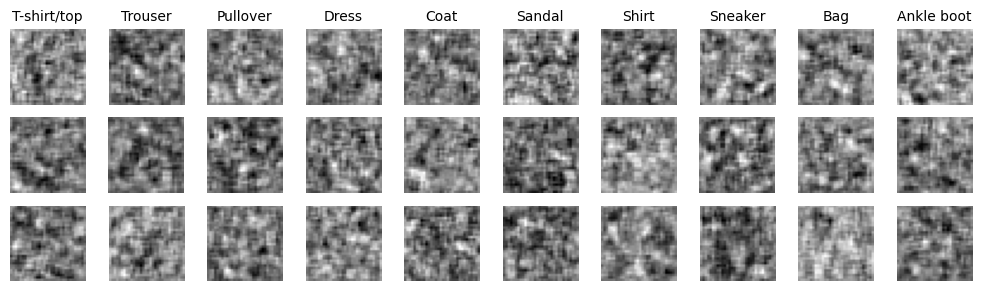

Epoch [21/30]  D_loss: 2.6330  G_loss: 0.3251
Epoch [22/30]  D_loss: 2.6330  G_loss: 0.3251
Epoch [23/30]  D_loss: 2.6331  G_loss: 0.3251
Epoch [24/30]  D_loss: 2.6332  G_loss: 0.3251
Epoch [25/30]  D_loss: 2.6333  G_loss: 0.3251
Epoch [26/30]  D_loss: 2.6334  G_loss: 0.3251
Epoch [27/30]  D_loss: 2.6335  G_loss: 0.3251
Epoch [28/30]  D_loss: 2.6335  G_loss: 0.3251
Epoch [29/30]  D_loss: 2.6336  G_loss: 0.3251
Epoch [30/30]  D_loss: 2.6335  G_loss: 0.3251


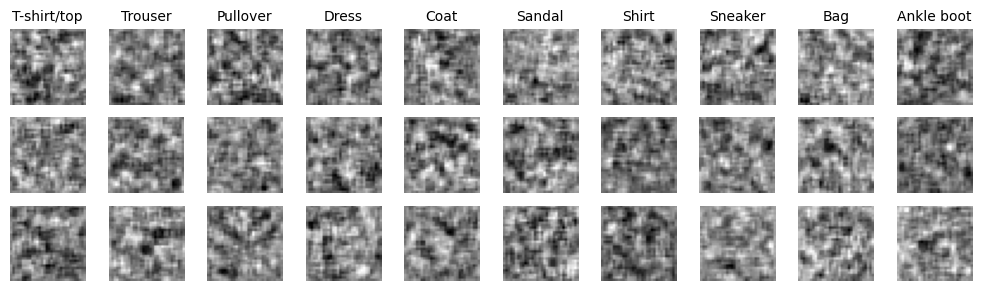

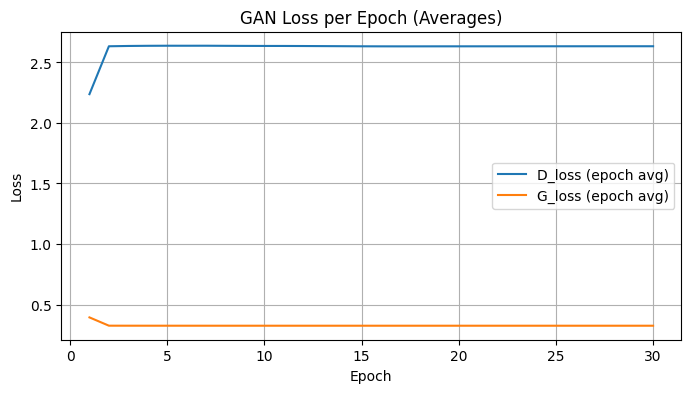

In [34]:
# history를 외부에서 선언
history = {"D": [], "G": []}

# 학습 수행 (기존 history를 그대로 넘겨줌)
history = train(
    generator, discriminator, train_loader,
    optimizer_G, optimizer_D, criterion,
    device, latent_dim, num_classes, epochs,
    history=history,                # 전달됨
    sample_every=10,
    real_target=0.9, fake_target=0.0,  # 라벨 스무딩 적용 가능
    idx_to_class=idx_to_class
)

plot_history(history)